# Simple Recurrent Network (SRN, Elman 1990) applied to sMNIST

## Equations
State update:

$
\vec{h}_t = \tanh(W_{hx}\vec{x}_t + W_{hh}\vec{h}_{t-1} + \vec{b}_h) \text{ with }\vec{h}_t \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x}
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

In [3]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [1]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [2]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [3]:
DATASET_VERSION = 'row' # sequential or row
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [4]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 28, 28) (128,)
int64


In [10]:
from typing import Sequence

class RNNLayer(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):

        def update(h, x):
            x = jnp.concatenate([h, x])
            h_new = jnp.tanh(nn.Dense(h.shape[0])(x))
            return h_new, h_new
        
        state_hist = []
        state = jnp.zeros((self.hidden_size,))
        for t in range(x.shape[0]):
            state, _ = update(state, x[t])
            state_hist.append(state)

        return jnp.stack(state_hist)

class RNNBackbone(nn.Module):
    hidden_size: int
    output_size: int
    num_layers: int

    @nn.compact
    def __call__(self, x):
        state_hist = []
        for _ in range(self.num_layers-1):
            x = RNNLayer(self.hidden_size, self.output_size)(x)
            state_hist.append(x)
        x = RNNLayer(self.hidden_size, self.output_size)(x)
        state_hist.append(x)
        out = nn.Dense(self.output_size, name='Dense_Out')(x)
        return state_hist, out
    
BatchRNN = nn.vmap(RNNBackbone, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [ ]:
model = BatchRNN(256, 10, 1)
params = model.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
state_hist, out_hist = model.apply(params, batch_x[:5])
print(len(state_hist), state_hist[0].shape, out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

1 (5, 28, 256) (5, 28, 10)
(5, 10)
[[-0.097 -0.074 -0.012  0.081 -0.09  -0.174 -0.057 -0.037 -0.056  0.025]
 [-0.072  0.003 -0.053  0.19   0.012 -0.058 -0.06  -0.091 -0.047  0.029]
 [-0.066 -0.068  0.033  0.093 -0.021 -0.09  -0.057 -0.111 -0.082 -0.063]
 [-0.195 -0.07   0.047  0.059  0.045 -0.243 -0.053 -0.061 -0.114  0.011]
 [-0.176 -0.081  0.042  0.045 -0.022 -0.22  -0.027 -0.104 -0.058  0.001]]


In [12]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())

(5,)
[2.293 2.344 2.329 2.445 2.268]
2.3356235


In [18]:
print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))


params: 
 {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_0': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_1': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_10': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_11': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_12': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_13': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_14': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_15': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_16': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_17': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_18': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_19': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_2': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_20': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_21': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_22': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_23': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_24': {'bias': (256,), 'kernel': (2

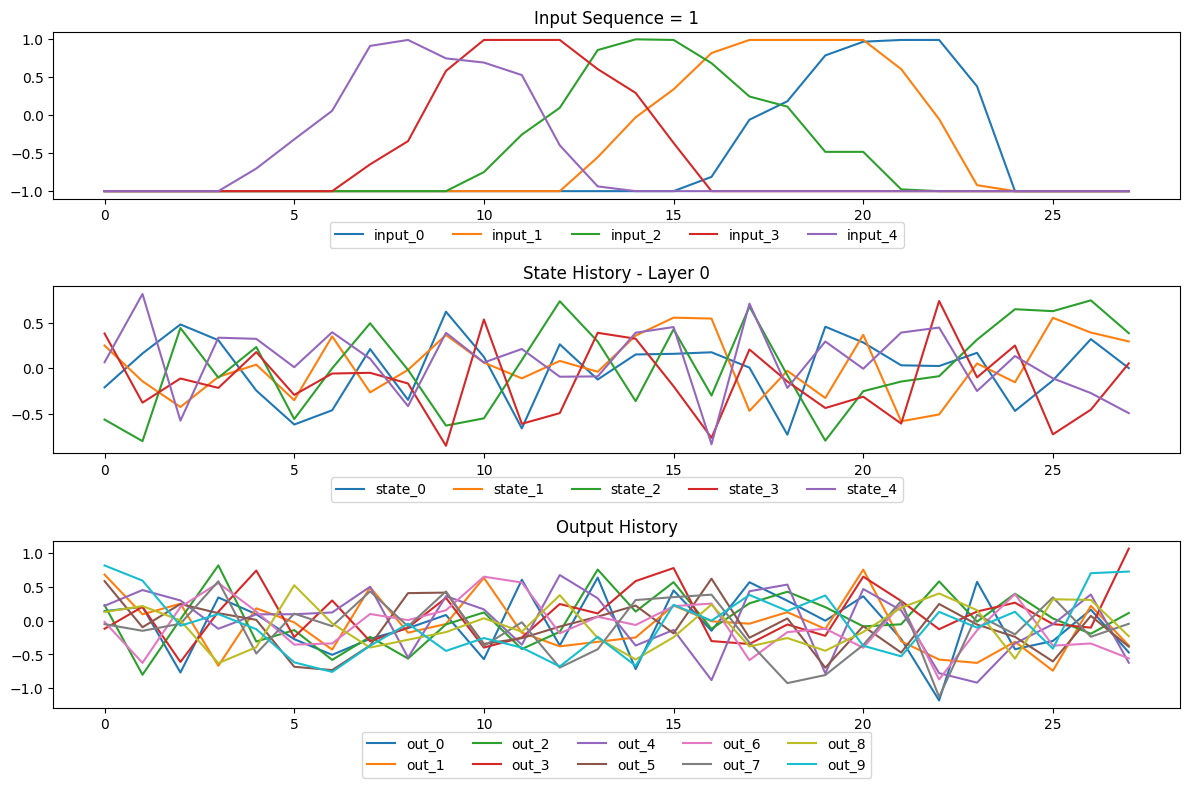

In [ ]:
plot_dynamics(model, params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)

In [20]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-2

In [21]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [22]:
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [23]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [24]:
def create_train_state(key, model_cls, lr, dataset_version):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=256, output_size=10, num_layers=1)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [25]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION)

Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_0': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_1': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_10': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_11': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_12': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_13': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_14': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_15': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_16': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_17': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_18': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_19': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_2': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_20': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_21': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_22': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_23': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_24': {'bias'

In [26]:
for epoch in range(30):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training: 100%|██████████| 468/468 [02:02<00:00,  3.83it/s, accuracy=0.852, loss=0.567]


Epoch 0 | Loss: 0.589563250541687 | Accuracy: 0.8118823170661926


Training: 100%|██████████| 468/468 [01:59<00:00,  3.91it/s, accuracy=0.797, loss=0.542]


Epoch 1 | Loss: 0.449187308549881 | Accuracy: 0.8675380349159241


Training:  27%|██▋       | 128/468 [00:32<01:27,  3.88it/s, accuracy=0.828, loss=0.583]


KeyboardInterrupt: 

In [27]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'RNNLayer_0': {'Dense_0': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_1': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_10': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_11': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_12': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_13': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_14': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_15': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_16': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_17': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_18': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_19': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_2': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_20': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_21': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_22': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_23': {'bias': (256,), 'kernel': (284, 256)}, 'Dense_24': {'bias': (256,), 'kernel': (284, 256)}, 

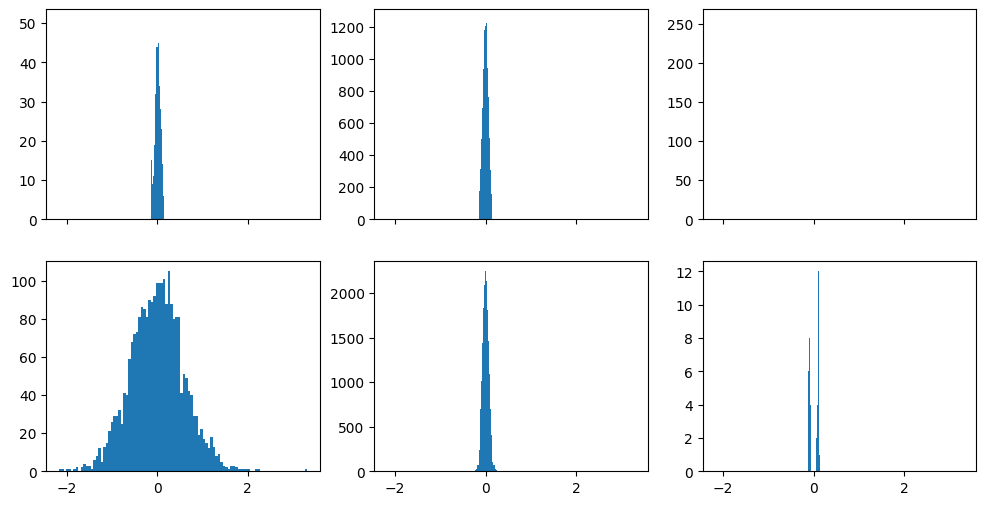

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(1200*px, 600*px), sharex=True)
axs[0,0].hist(params['params']['Dense_Out']['kernel'].flatten(), bins=100)
axs[0,1].hist(params['params']['RNNLayer_0']['Dense_0']['kernel'].flatten(), bins=100)
axs[0,2].hist(params['params']['RNNLayer_0']['Dense_0']['bias'].flatten(), bins=100)
axs[1,0].hist(state.params['Dense_Out']['kernel'].flatten(), bins=100)
axs[1,1].hist(state.params['RNNLayer_0']['Dense_0']['kernel'].flatten(), bins=100)
axs[1,2].hist(state.params['RNNLayer_0']['Dense_0']['bias'].flatten(), bins=100)
plt.show()

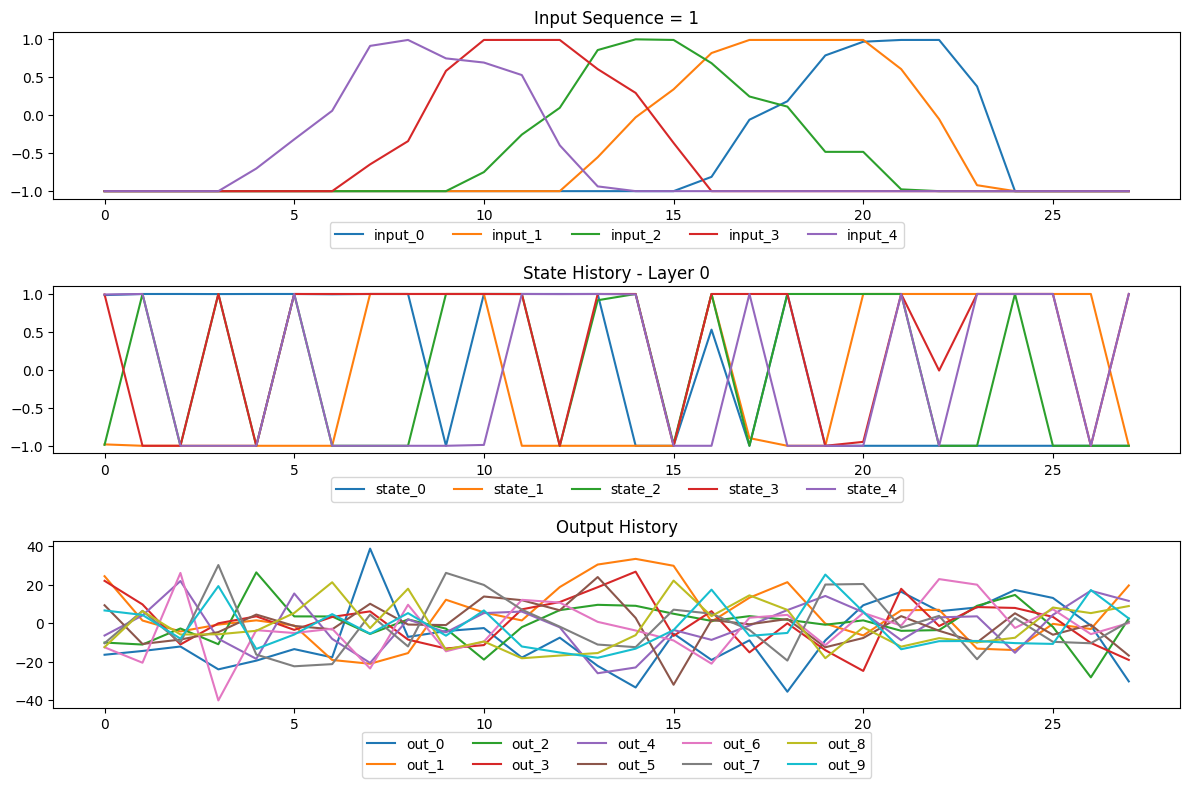

In [31]:
plot_dynamics(model, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)